In [2]:
%matplotlib inline

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.utils.data import Dataset, DataLoader

EPS = 1e-5  # define a small constant for numerical stability control

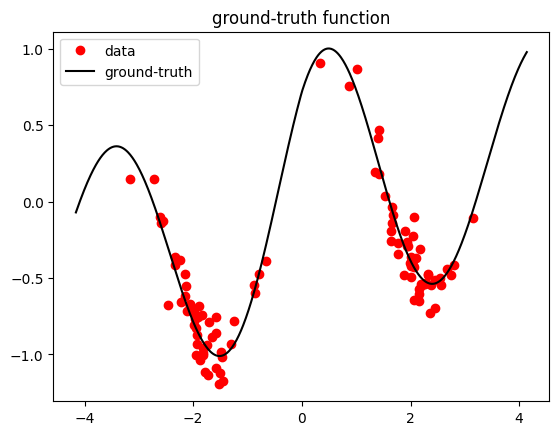

In [3]:
def ground_truth_func(x):
    return np.sin(x * math.pi / 2 + 0.8) * np.exp(-0.1 * np.abs(x)) + 0.1 * x

def gen_data(N_data, ground_truth_func, noise_std=None): 
    # generate the training dataset, note here we will make data into 2 clusters
    x1 = np.random.randn(int(N_data/2), 1) * 0.5 + 2.0
    x2 = np.random.randn(int(N_data/2), 1) * 0.5 - 2.0
    x = np.concatenate([x1, x2], axis=0)
    y = ground_truth_func(x)
    if noise_std is not None and noise_std > EPS:
        # assume homogeneous noise setting, i.e., "homoscedasticity"
        y += np.random.randn(y.shape[0], y.shape[1]) * noise_std
    return x, y

def normalise_data(x, mean, std):
    return (x - mean) / std

def unnormalise_data(x, mean, std):
    return x * std + mean

class regression_data(Dataset):
     def __init__(self, x, y, normalise=True):
         super(regression_data, self).__init__()
         self.update_data(x, y, normalise)

     def __len__(self):
         return self.x.shape[0]

     def __getitem__(self, index):
         x = torch.tensor(self.x[index]).float()
         y = torch.tensor(self.y[index]).float()
         return x, y

     def update_data(self, x, y, normalise=True, update_stats=True):
         assert x.shape[0] == y.shape[0]
         self.x = x
         self.y = y
         # normalise data
         self.normalise = normalise
         if update_stats:
             self.x_mean = self.x.mean(0) if normalise else 0.0
             self.x_std = self.x.std(0) if normalise else 1.0
             self.y_mean = self.y.mean(0) if normalise else 0.0
             self.y_std = self.y.std(0) if normalise else 1.0
         if self.normalise:
             self.x = normalise_data(self.x, self.x_mean, self.x_std)
             self.y = normalise_data(self.y, self.y_mean, self.y_std)

N_data = 100
noise_std = 0.1
x_train, y_train = gen_data(N_data, ground_truth_func, noise_std)
dataset = regression_data(x_train, y_train)
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

# plot the training data and ground truth
x_test = np.arange(np.min(x_train) - 1.0, np.max(x_train)+1.0, 0.01)[:, np.newaxis]
y_test = ground_truth_func(x_test)
plt.plot(x_train, y_train, 'ro', label='data')
plt.plot(x_test, y_test, 'k-', label='ground-truth')
plt.legend()
plt.title('ground-truth function')
plt.show()

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

def gauss_loglik(y, y_pred, log_noise_var):
    # y should have shape as (batch_size, y_dim)
    # y_pred should have shape as (batch_size, y_dim) or (K, batch_size, y_dim)
    # where K is the number of MC samples
    # this function should return per-data loss of shape (batch_size,) or (K, batch_size)
    ### begin of your code ###
    # hint: consult with your textbook or wikipedia for the Gaussian distribution form
    l2_dist=(y-y_pred).pow(2).sum(-1)
    ll = -0.5 * (log_noise_var + math.log(2 * math.pi) + l2_dist * torch.exp(-log_noise_var))

    ### end of your code ###
    return ll

# we assume a Gaussian likelihood with homogeneuous noise
log_noise_var = nn.Parameter(torch.ones(size=(), device=device)*-3.0)

data_loss_func = lambda y, y_pred: -gauss_loglik(y, y_pred, log_noise_var)
nll = data_loss_func(y, y_pred).mean()

In [13]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from matplotlib.ticker import LogLocator
from matplotlib.ticker import LogLocator, FormatStrFormatter

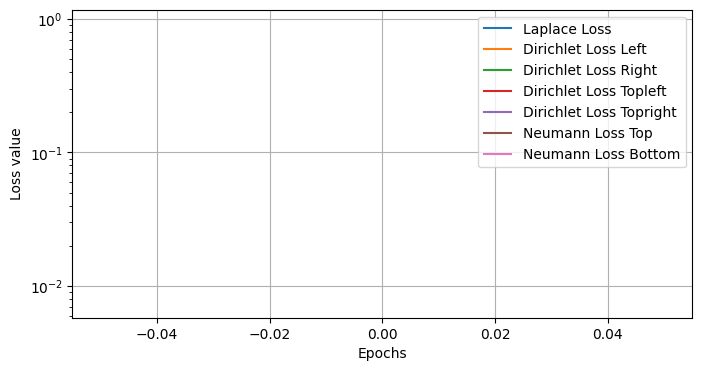

Epoch 0, Loss: 1023.5615234375


In [3]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]  # Change Tanh to GeLU
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())  # Change Tanh to GeLU
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points

def plot_losses(epochs, losses_dict):
    plt.figure(figsize=(8, 4))
    
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epochs, loss_values, label=loss_name)
    plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()


def closure():
    # Compute individual loss terms
    loss_laplace = laplace_residual(model, train_points)
    loss_d_l = loss_dirichlet_boundary(model, boundary_points_dirichlet_left, target_points_dirichlet_left)
    loss_d_r = loss_dirichlet_boundary(model, boundary_points_dirichlet_right, target_points_dirichlet_right)
    loss_d_tl = loss_dirichlet_boundary(model, boundary_points_dirichlet_topleft, target_points_dirichlet_topleft)
    loss_d_tr = loss_dirichlet_boundary(model, boundary_points_dirichlet_topright, target_points_dirichlet_topright)
    loss_n_t = loss_neumann_boundary(model, boundary_points_neumann_top, axis='horizontal')
    loss_n_b = loss_neumann_boundary(model, boundary_points_neumann_bottom, axis='horizontal')
    
    # Combine losses using the updated weights
    loss = (
        loss_weights[0] * loss_laplace +
        loss_weights[1] * loss_d_l +
        loss_weights[2] * loss_d_r +
        loss_weights[3] * loss_d_tl +
        loss_weights[4] * loss_d_tr +
        loss_weights[5] * loss_n_t +
        loss_weights[6] * loss_n_b
    )
    
    # Record losses and weights
    laplace_losses.append(loss_laplace.item())
    dirichlet_losses_left.append(loss_d_l.item())
    dirichlet_losses_right.append(loss_d_r.item())
    dirichlet_losses_topleft.append(loss_d_tl.item())
    dirichlet_losses_topright.append(loss_d_tr.item())
    neumann_losses_top.append(loss_n_t.item())
    neumann_losses_bottom.append(loss_n_b.item())
    epochs_recorded.append(epoch)

    return loss

#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 0.2

left_dirichlet,target_left_dirichlet = create_boundary_points('vertical', left, 0, top, 1000, 1)  # Left boundary
boundary_points_dirichlet_left=torch.cat([left_dirichlet],dim=0).requires_grad_(True)  # Concatenate Dirichlet boundary points
target_points_dirichlet_left=torch.cat([target_left_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

right_dirichlet, target_right_dirichlet = create_boundary_points('vertical', right, 0, top, 1000, 0) # Right boundary
boundary_points_dirichlet_right=torch.cat([right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary points
target_points_dirichlet_right=torch.cat([target_right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

topleft_dirichlet, target_topleft_dirichlet= create_boundary_points('horizontal', top, 0, 0.3*right, 3000, 1)
boundary_points_dirichlet_topleft=torch.cat([topleft_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topleft=torch.cat([target_topleft_dirichlet],dim=0).requires_grad_(True)

topright_dirichlet,target_topright_dirichlet = create_boundary_points('horizontal', top, 0.7*right, 1*right, 3000, 0)
boundary_points_dirichlet_topright=torch.cat([topright_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topright=torch.cat([target_topright_dirichlet],dim=0).requires_grad_(True)

top_neumann=create_boundary_points('horizontal', top, 0.3*right, 0.7*right, 3000)
boundary_points_neumann_top=torch.cat([top_neumann],dim=0).requires_grad_(True)

bottom_neumann=create_boundary_points('horizontal', bottom, 0, right, 1000)
boundary_points_neumann_bottom=torch.cat([bottom_neumann],dim=0).requires_grad_(True)


# Creating domain points
num_domain_points=6500
x_points = torch.rand(num_domain_points,1) 
x = (x_points*right).requires_grad_(True)
y_points = torch.rand(num_domain_points,1)
y=(y_points*top).requires_grad_(True)
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses_left = []
dirichlet_losses_right = []
dirichlet_losses_topleft = []
dirichlet_losses_topright = []
neumann_losses_top = []
neumann_losses_bottom = []
epochs_recorded = []


#Defining hyperparameters:
model=pinn(hidden_size=20, hidden_layers=8) 

epochs=2001

# Initialize the loss weights
lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b = 2,100,100,1000,1000,100,100
loss_weights = (torch.tensor([lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b], 
                            dtype=torch.float, requires_grad=False))

adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Initialize the weights and biases of the model
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Use Xavier initialization
        nn.init.zeros_(m.bias)  # Initialize biases to zero
# Apply weight initialization
model.apply(initialize_weights)


#Training loop:
for epoch in range(epochs):
    adam_optimizer.zero_grad()
    loss=closure()
    loss.backward()
    adam_optimizer.step() # Update the weights and biases of the model

    # Logging
    if epoch % 6000 == 0:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)
        print(f"Epoch {epoch}, Loss: {loss.item()}")

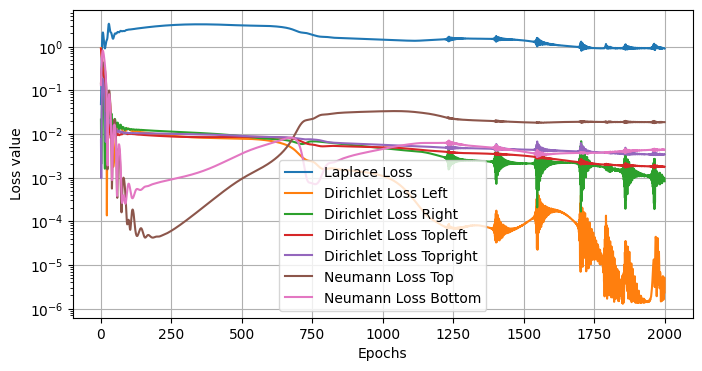

Epoch 2000, Loss: 9.33971881866455


In [ ]:
losses_dict = {
    "Laplace Loss": laplace_losses,
    "Dirichlet Loss Left": dirichlet_losses_left,
    "Dirichlet Loss Right": dirichlet_losses_right,
    "Dirichlet Loss Topleft": dirichlet_losses_topleft,
    "Dirichlet Loss Topright": dirichlet_losses_topright,
    "Neumann Loss Top": neumann_losses_top,
    "Neumann Loss Bottom": neumann_losses_bottom
}

plot_losses(epochs_recorded, losses_dict)
print(f"Epoch {epoch}, Loss: {loss.item()}")

In [1]:
def damped_harmonic_oscillator(m, mu, k, y0, v0, t):
    # Check underdamped condition
    if mu**2 >= 4 * m * k:
        raise ValueError("The system is not underdamped. Ensure that μ^2 < 4 * m * k.")
    
    # Angular frequency
    omega = np.sqrt(k/m - (mu/(2*m)) ** 2)
    
    # Exact solution
    A = y0
    B = (v0 + (mu/(2*m)) * y0) / omega
    y_exact = np.exp(-mu * t / (2 * m)) * (A * np.cos(omega * t) + B * np.sin(omega * t))
    
    return y_exact

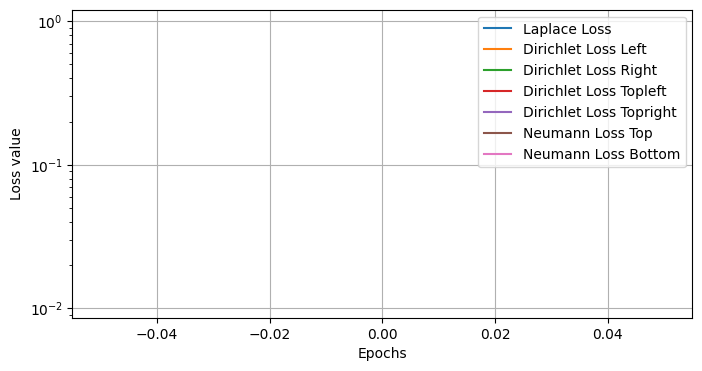

Epoch 0, Loss: 999.7322998046875


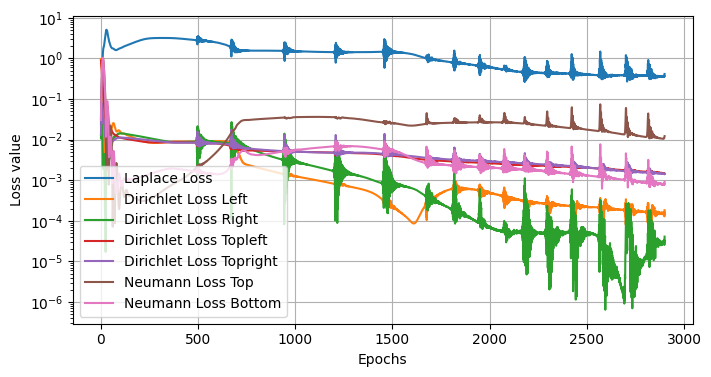

Epoch 2900, Loss: 5.020806312561035


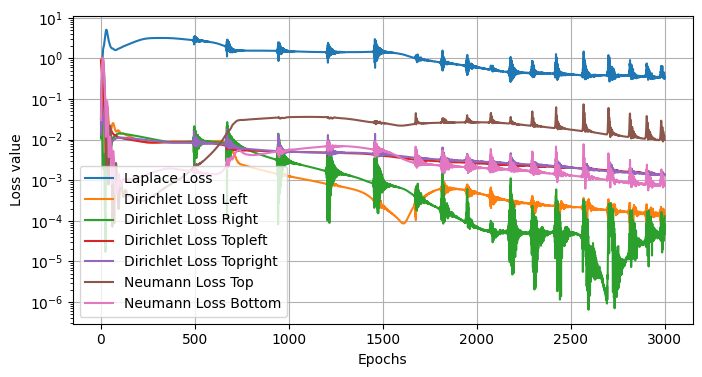

Epoch 3000, Loss: 4.459850311279297


In [14]:
def set_seed(seed=42):
    random.seed(seed)  # Python random module
    np.random.seed(seed)  # Numpy random module
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU
    torch.cuda.manual_seed_all(seed)  # All GPUs (if multiple)

# Set the seed
set_seed(123)

# Define the neural network for the Physics-Informed Neural Network (PINN)
class pinn(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3):
        super(pinn, self).__init__()
        layers = [nn.Linear(2, hidden_size), nn.Tanh()]  # Change Tanh to GeLU
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())  # Change Tanh to GeLU
        layers.append(nn.Linear(hidden_size, 1))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def laplace_residual(model, coords):
    u = model(coords)
    grads = torch.autograd.grad(u, coords, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(grads[:, 0], coords, grad_outputs=torch.ones_like(grads[:, 0]), create_graph=True)[0][:, 0]
    u_yy = torch.autograd.grad(grads[:, 1], coords, grad_outputs=torch.ones_like(grads[:, 1]), create_graph=True)[0][:, 1]
    return torch.mean((u_xx + u_yy) ** 2)

#Boundary conditions:
def loss_dirichlet_boundary(model,boundary_points,boundary_target):
    u_pred = model(boundary_points)
    boundary_residual= u_pred-boundary_target
    return torch.mean((boundary_residual)**2)

def loss_neumann_boundary(model,boundary_points,axis='horizontal'):
    u_pred = model(boundary_points)
    u_grad= torch.autograd.grad(u_pred,boundary_points,grad_outputs=torch.ones_like(u_pred),create_graph=True)[0] #This is the gradient of u 
    if axis=='vertical':
        u_x = u_grad[:,0] # This is the x-component of the gradient of u
        return torch.mean((u_x)**2)
    elif axis=='horizontal':
        u_y = u_grad[:,1] # This is the y-component of the gradient of u
        return torch.mean((u_y)**2)

# Function to create boundary points
def create_boundary_points(axis, place, start, end, num_points, head=None):
    line_points = torch.full((num_points, 1), place)
    place_points = start + (end - start) * torch.rand(num_points, 1)
    
    if axis == 'vertical':
        boundary_points = torch.cat([line_points, place_points], dim=1)
    elif axis == 'horizontal':
        boundary_points = torch.cat([place_points, line_points], dim=1)

    # Only return targets if head value is provided (for Dirichlet conditions)
    if head is not None:
        boundary_targets = torch.full((num_points, 1), head, dtype=torch.float)
        return boundary_points, boundary_targets
    else:
        return boundary_points

def plot_losses(epochs, losses_dict):
    plt.figure(figsize=(8, 4))
    
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epochs, loss_values, label=loss_name)
    plt.gca().yaxis.set_major_locator(LogLocator(base=10.0))
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    plt.yscale('log')
    plt.xlabel("Epochs")
    plt.ylabel("Loss value")
    plt.grid()
    plt.legend()
    plt.show()


def closure():
    optimizer.zero_grad()

    # Compute individual loss terms
    loss_laplace = laplace_residual(model, train_points)
    loss_d_l = loss_dirichlet_boundary(model, boundary_points_dirichlet_left, target_points_dirichlet_left)
    loss_d_r = loss_dirichlet_boundary(model, boundary_points_dirichlet_right, target_points_dirichlet_right)
    loss_d_tl = loss_dirichlet_boundary(model, boundary_points_dirichlet_topleft, target_points_dirichlet_topleft)
    loss_d_tr = loss_dirichlet_boundary(model, boundary_points_dirichlet_topright, target_points_dirichlet_topright)
    loss_n_t = loss_neumann_boundary(model, boundary_points_neumann_top, axis='horizontal')
    loss_n_b = loss_neumann_boundary(model, boundary_points_neumann_bottom, axis='horizontal')
    
    # Combine losses using the updated weights
    loss = (
        loss_weights[0] * loss_laplace +
        loss_weights[1] * loss_d_l +
        loss_weights[2] * loss_d_r +
        loss_weights[3] * loss_d_tl +
        loss_weights[4] * loss_d_tr +
        loss_weights[5] * loss_n_t +
        loss_weights[6] * loss_n_b
    )

    loss.backward()
    
    # Record losses and weights
    laplace_losses.append(loss_laplace.item())
    dirichlet_losses_left.append(loss_d_l.item())
    dirichlet_losses_right.append(loss_d_r.item())
    dirichlet_losses_topleft.append(loss_d_tl.item())
    dirichlet_losses_topright.append(loss_d_tr.item())
    neumann_losses_top.append(loss_n_t.item())
    neumann_losses_bottom.append(loss_n_b.item())
    epochs_recorded.append(epoch)
    loss_recorded.append(loss.item())

    return loss

#_____________________________________________________________________________________________________________

#Domain size:
left, right, bottom, top = 0, 1, 0, 0.2

left_dirichlet,target_left_dirichlet = create_boundary_points('vertical', left, 0, top, 1000, 1)  # Left boundary
boundary_points_dirichlet_left=torch.cat([left_dirichlet],dim=0).requires_grad_(True)  # Concatenate Dirichlet boundary points
target_points_dirichlet_left=torch.cat([target_left_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

right_dirichlet, target_right_dirichlet = create_boundary_points('vertical', right, 0, top, 1000, 0) # Right boundary
boundary_points_dirichlet_right=torch.cat([right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary points
target_points_dirichlet_right=torch.cat([target_right_dirichlet],dim=0).requires_grad_(True) # Concatenate Dirichlet boundary targets

topleft_dirichlet, target_topleft_dirichlet= create_boundary_points('horizontal', top, 0, 0.3*right, 3000, 1)
boundary_points_dirichlet_topleft=torch.cat([topleft_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topleft=torch.cat([target_topleft_dirichlet],dim=0).requires_grad_(True)

topright_dirichlet,target_topright_dirichlet = create_boundary_points('horizontal', top, 0.7*right, 1*right, 3000, 0)
boundary_points_dirichlet_topright=torch.cat([topright_dirichlet],dim=0).requires_grad_(True)
target_points_dirichlet_topright=torch.cat([target_topright_dirichlet],dim=0).requires_grad_(True)

top_neumann=create_boundary_points('horizontal', top, 0.3*right, 0.7*right, 3000)
boundary_points_neumann_top=torch.cat([top_neumann],dim=0).requires_grad_(True)

bottom_neumann=create_boundary_points('horizontal', bottom, 0, right, 1000)
boundary_points_neumann_bottom=torch.cat([bottom_neumann],dim=0).requires_grad_(True)


# Creating domain points
num_domain_points=10000
x_points = torch.rand(num_domain_points,1) 
x = (x_points*right).requires_grad_(True)
y_points = torch.rand(num_domain_points,1)
y=(y_points*top).requires_grad_(True)
train_points=torch.cat([x,y],dim=1) 

# Initialize lists to store losses and plot
laplace_losses = []
dirichlet_losses_left = []
dirichlet_losses_right = []
dirichlet_losses_topleft = []
dirichlet_losses_topright = []
neumann_losses_top = []
neumann_losses_bottom = []
epochs_recorded = []
loss_recorded = []


#Defining hyperparameters:
model=pinn(hidden_size=20, hidden_layers=8) 

epochs=3001

# Initialize the loss weights
lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b = 2,100,100,1000,1000,100,100
loss_weights = (torch.tensor([lambda_laplace, y_d_l, y_d_r, y_d_tl, y_d_tr, y_n_t, y_n_b], 
                            dtype=torch.float, requires_grad=False))

adam_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, max_iter=20)

# Initialize the weights and biases of the model
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Use Xavier initialization
        nn.init.zeros_(m.bias)  # Initialize biases to zero
# Apply weight initialization
model.apply(initialize_weights)


#Training loop:
for epoch in range(epochs):
    optimizer = adam_optimizer if epoch < 6001 else lbfgs_optimizer
    optimizer.step(closure) # Update the weights and biases of the model

    # Logging

    if epoch % 2900 == 0 and epoch <= 6000:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)
        print(f"Epoch {epoch}, Loss: {loss_recorded[-1]}")
    
    if epoch % 100 == 0 and epoch > 2900:
        losses_dict = {
            "Laplace Loss": laplace_losses,
            "Dirichlet Loss Left": dirichlet_losses_left,
            "Dirichlet Loss Right": dirichlet_losses_right,
            "Dirichlet Loss Topleft": dirichlet_losses_topleft,
            "Dirichlet Loss Topright": dirichlet_losses_topright,
            "Neumann Loss Top": neumann_losses_top,
            "Neumann Loss Bottom": neumann_losses_bottom
        }

        plot_losses(epochs_recorded, losses_dict)
        print(f"Epoch {epoch}, Loss: {loss_recorded[-1]}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def run_monte_carlo_simulation(num_samples, t, m, mu, k, y0, v0, damped_harmonic_oscillator, y_threshold=-1):
    """
    Runs a Monte Carlo simulation for the damped harmonic oscillator.
    """
    m_samples = np.random.normal(m, 0.1, num_samples)
    mu_samples = np.random.normal(mu, 0.05, num_samples)
    k_samples = np.random.normal(k, 0.2, num_samples)
    y0_samples = np.random.normal(y0, 0.0, num_samples)
    
    y_mc = [damped_harmonic_oscillator(m_samples[i], mu_samples[i], k_samples[i], y0_samples[i], v0, t) for i in range(num_samples)]
    
    y_mc = np.array(y_mc)
    y_mean = np.mean(y_mc, axis=0)
    y_std = np.std(y_mc, axis=0)
    prob_exceed = np.mean(np.any(y_mc < y_threshold, axis=1))
    
    return y_mc, y_mean, y_std, prob_exceed

def plot_monte_carlo_results(t, y_exact, y_mean, y_std):
    """
    Plots the mean and standard deviation of the Monte Carlo simulation.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(t, y_exact, label='Exact Solution', color='red')
    plt.plot(t, y_mean, label='Mean', color='blue')
    plt.fill_between(t, y_mean - 3 * y_std, y_mean + 3 * y_std, color='blue', alpha=0.1, label='3 Standard Deviations')
    plt.fill_between(t, y_mean - 2 * y_std, y_mean + 2 * y_std, color='blue', alpha=0.2, label='2 Standard Deviations')
    plt.fill_between(t, y_mean - y_std, y_mean + y_std, color='blue', alpha=0.3, label='1 Standard Deviation')
    plt.title('Monte Carlo Simulation of Damped Harmonic Oscillator')
    plt.xlabel('Time (t)')
    plt.ylabel('Displacement (y)')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

class ParamPINN(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3, dropout_rate=0.05):
        super(ParamPINN, self).__init__()
        input_dim = 6
        layers = [nn.Linear(input_dim, hidden_size), nn.Tanh()]
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, m, mu, k, y0, v0):
        N = t.shape[0]
        x = torch.cat([t, m.expand(N, 1), mu.expand(N, 1), k.expand(N, 1), y0.expand(N, 1), v0.expand(N, 1)], dim=1)
        return self.net(x)

def pde_loss(model, t, m, mu, k, y0_val, v0_val):
    y = model(t, m, mu, k, y0_val, v0_val)
    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    residual = m * y_tt + mu * y_t + k * y
    return torch.mean(residual**2)

def boundary_loss(model, t0, m, mu, k, y0, v0):
    y_pred = model(t0, m, mu, k, y0, v0)
    y_t = torch.autograd.grad(y_pred, t0, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return (y_pred - y0)**2 + (y_t - v0)**2

def plot_loss(epoch, losses_dict):
    plt.figure(figsize=(5, 3))
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epoch, loss_values, label=loss_name)
    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def initialize_parameters():
    t_coll = torch.rand(500,1)*5
    t_coll.requires_grad_(True)
    
    m, mu, k = 1.0, 0.6, 5.0
    y0, v0 = -0.4, 3.0
    
    m_val  = torch.tensor([[m]], requires_grad=True)
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val  = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)
    
    t0 = torch.tensor([0.0]).view(-1,1).requires_grad_(True)
    
    return t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0

def train_model(model, optimizer, t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0, epochs=4001):
    epoch_recorded = []
    pde_loss_recorded = []
    boundary_loss_recorded = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss_pde = pde_loss(model, t_coll, m_val, mu_val, k_val, y0_val, v0_val)
        loss_bc  = boundary_loss(model, t0, m_val, mu_val, k_val, y0_val, v0_val)
        loss = loss_pde + 10 * loss_bc
        loss.backward()
        optimizer.step()

        epoch_recorded.append(epoch)
        pde_loss_recorded.append(loss_pde.item())
        boundary_loss_recorded.append(loss_bc.item())
        
        if epoch % 2000 == 0:
            print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}")
            losses_dict = {'Residual Loss': pde_loss_recorded, 'Boundary Loss': boundary_loss_recorded}
            print(f"Epoch {epoch}, Loss: {loss.item()}")
            plot_loss(epoch_recorded, losses_dict)

# Running the training pipeline
set_seed()
t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0 = initialize_parameters()
model = ParamPINN(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_model(model, optimizer, t_coll, m_val, mu_val, k_val, y0_val, v0_val, t0)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# Define the PINN model
class ParamPINN(nn.Module):
    def __init__(self, hidden_size=20, hidden_layers=3, dropout_rate=0.05):
        super(ParamPINN, self).__init__()
        input_dim = 6
        layers = [nn.Linear(input_dim, hidden_size), nn.Tanh()]
        
        for _ in range(hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout_rate))
        
        layers.append(nn.Linear(hidden_size, 1))
        self.net = nn.Sequential(*layers)
    
    def forward(self, t, m, mu, k, y0, v0):
        N = t.shape[0]
        mu_ = mu.expand(N, -1)
        k_  = k.expand(N, -1)
        y0_ = y0.expand(N, -1)
        v0_ = v0.expand(N, -1)
        x = torch.cat([t, m, mu_, k_, y0_, v0_], dim=1)
        return self.net(x)

# Compute PDE loss
def pde_loss(model, t, m, mu, k, y0_val, v0_val):
    y = model(t, m, mu, k, y0_val, v0_val)
    y_t = torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    y_tt = torch.autograd.grad(y_t, t, grad_outputs=torch.ones_like(y_t), create_graph=True)[0]
    residual = m * y_tt + mu * y_t + k * y
    return torch.mean(residual**2)

# Compute boundary loss
def boundary_loss(model, t0, m, mu, k, y0, v0):
    y_pred = model(t0, m, mu, k, y0, v0)
    y_t = torch.autograd.grad(y_pred, t0, grad_outputs=torch.ones_like(y_pred), create_graph=True)[0]
    return torch.mean((y_pred - y0)**2 + (y_t - v0)**2)

# Plot loss function
def plot_loss(epoch, losses_dict):
    plt.figure(figsize=(5, 3))
    for loss_name, loss_values in losses_dict.items():
        plt.plot(epoch, loss_values, label=loss_name)
    plt.yscale('log')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Initialize training parameters
def initialize_parameters():
    N = 500
    t_coll = torch.rand(N, 1) * 5
    t_coll.requires_grad_(True)
    m_mean, m_std = 2.0, 0.2
    m_coll = m_mean + m_std * torch.randn((N, 1)) # Sample from standard normal and scale
    m_coll.requires_grad_(True) # Set requires_grad to True for backpropagation
    mu, k, y0, v0 = 0.6, 5.0, -0.4, 3.0
    # Define parameters as scalars (shape (1, 1))
    mu_val = torch.tensor([[mu]], requires_grad=True)
    k_val = torch.tensor([[k]], requires_grad=True)
    y0_val = torch.tensor([[y0]], requires_grad=True)
    v0_val = torch.tensor([[v0]], requires_grad=True)

    # Also define a single time for boundary condition
    t0 = torch.zeros_like(t_coll).clone().detach().requires_grad_(True)

    return t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0

# Trainer class to manage training process
class Trainer:
    def __init__(self, model, optimizer, epochs=4001):
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.losses = {"Residual Loss": [], "Boundary Loss": []}
        self.lambda_bc = 10.0
    
    def train(self, t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0):
        for epoch in range(self.epochs):
            self.optimizer.zero_grad()
            loss_pde = pde_loss(self.model, t_coll, m_coll, mu_val, k_val, y0_val, v0_val)
            loss_bc = boundary_loss(self.model, t0, m_coll, mu_val, k_val, y0_val, v0_val)
            loss = loss_pde + self.lambda_bc * loss_bc
            loss.backward()
            self.optimizer.step()
            
            self.losses["Residual Loss"].append(loss_pde.item())
            self.losses["Boundary Loss"].append(loss_bc.item())
            
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}, PDE loss: {loss_pde.item()}, BC loss: {loss_bc.item()}")
                plot_loss(range(epoch + 1), self.losses)

# Run training pipeline
set_seed()
t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0 = initialize_parameters()
model = ParamPINN(hidden_size=20, hidden_layers=3, dropout_rate=0.0)
optimizer = optim.Adam(model.parameters(), lr=0.01)
trainer = Trainer(model, optimizer)
trainer.train(t_coll, m_coll, mu_val, k_val, y0_val, v0_val, t0)
